In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from itertools import product

from tqdm import tqdm


In [2]:
df = pd.read_csv(r'datos\robust.csv', index_col = 0)

In [3]:
df.dtypes

dateCrawled             object
name                    object
seller                  object
offerType               object
price                  float64
abtest                  object
vehicleType             object
yearOfRegistration      object
gearbox                 object
powerCV                float64
model                   object
kilometer              float64
monthOfRegistration     object
fuelType                object
brand                   object
notRepairedDamage       object
dateCreated             object
postalCode               int64
lastSeen                object
dtype: object

In [4]:
df["postalCode"] = df["postalCode"].astype('object')

In [5]:
df_numeric = df.select_dtypes('number')

Vamos a querer identificar los outliers de nuestra variable respuesta, precio, puesta en contexto con el resto de variables numéricas, powerCV y kilometer. Para ello, realizaremos una identificación de outliers multivariantes, tomando las 3 columnas numéricas como objeto de estudio.

Vamos a usar 5 valores de n de estimadores y de contaminaciones posibles, lo cual nos da 25 combinaciones posibles.

In [6]:
ests = np.linspace(1,1000, 5, dtype = int)
conts = np.linspace(0.01,0.2,5)

forest_arg_combis = list(product(ests, conts))

Generemos los Isolation Forest para cada una de las combinaciones y añadámoslas a una columna nueva.

In [7]:
for n,m in tqdm(forest_arg_combis):
    iforest = IsolationForest(random_state=42, n_estimators=n, contamination=m, n_jobs=12)
    df[f"iforest_{n}_{m:.3f}"] = iforest.fit_predict(X=df_numeric)
    print(f"Creando iforest_{n}_{m:.3f}...")

 12%|█▏        | 3/25 [00:00<00:02, 10.34it/s]

Creando iforest_1_0.010...
Creando iforest_1_0.058...
Creando iforest_1_0.105...


 20%|██        | 5/25 [00:00<00:01, 10.84it/s]

Creando iforest_1_0.153...
Creando iforest_1_0.200...
Creando iforest_250_0.010...


 28%|██▊       | 7/25 [00:20<01:18,  4.35s/it]

Creando iforest_250_0.058...


 32%|███▏      | 8/25 [00:30<01:36,  5.70s/it]

Creando iforest_250_0.105...


 36%|███▌      | 9/25 [00:41<01:49,  6.84s/it]

Creando iforest_250_0.153...


 40%|████      | 10/25 [00:52<01:58,  7.88s/it]

Creando iforest_250_0.200...


 44%|████▍     | 11/25 [01:13<02:40, 11.46s/it]

Creando iforest_500_0.010...


 48%|████▊     | 12/25 [01:33<03:03, 14.12s/it]

Creando iforest_500_0.058...


 52%|█████▏    | 13/25 [01:54<03:12, 16.06s/it]

Creando iforest_500_0.105...


 56%|█████▌    | 14/25 [02:15<03:11, 17.41s/it]

Creando iforest_500_0.153...


 60%|██████    | 15/25 [02:36<03:03, 18.34s/it]

Creando iforest_500_0.200...


 64%|██████▍   | 16/25 [03:07<03:20, 22.25s/it]

Creando iforest_750_0.010...


 68%|██████▊   | 17/25 [03:39<03:20, 25.04s/it]

Creando iforest_750_0.058...


 72%|███████▏  | 18/25 [04:10<03:07, 26.76s/it]

Creando iforest_750_0.105...


 76%|███████▌  | 19/25 [04:41<02:49, 28.17s/it]

Creando iforest_750_0.153...


 80%|████████  | 20/25 [05:18<02:33, 30.75s/it]

Creando iforest_750_0.200...


 84%|████████▍ | 21/25 [06:05<02:21, 35.48s/it]

Creando iforest_1000_0.010...


 88%|████████▊ | 22/25 [06:50<01:55, 38.47s/it]

Creando iforest_1000_0.058...


 92%|█████████▏| 23/25 [07:40<01:23, 41.77s/it]

Creando iforest_1000_0.105...


 96%|█████████▌| 24/25 [08:30<00:44, 44.33s/it]

Creando iforest_1000_0.153...


100%|██████████| 25/25 [09:19<00:00, 22.37s/it]

Creando iforest_1000_0.200...


Vamos a crear un nuevo dataframe que contenga cada uno de los resultados obtenidos con cada una de las combinaciones con IsolationForest.

In [8]:
df_forest = df.filter(like="iforest")

Ploteamos en 3D, cada variable en un eje.

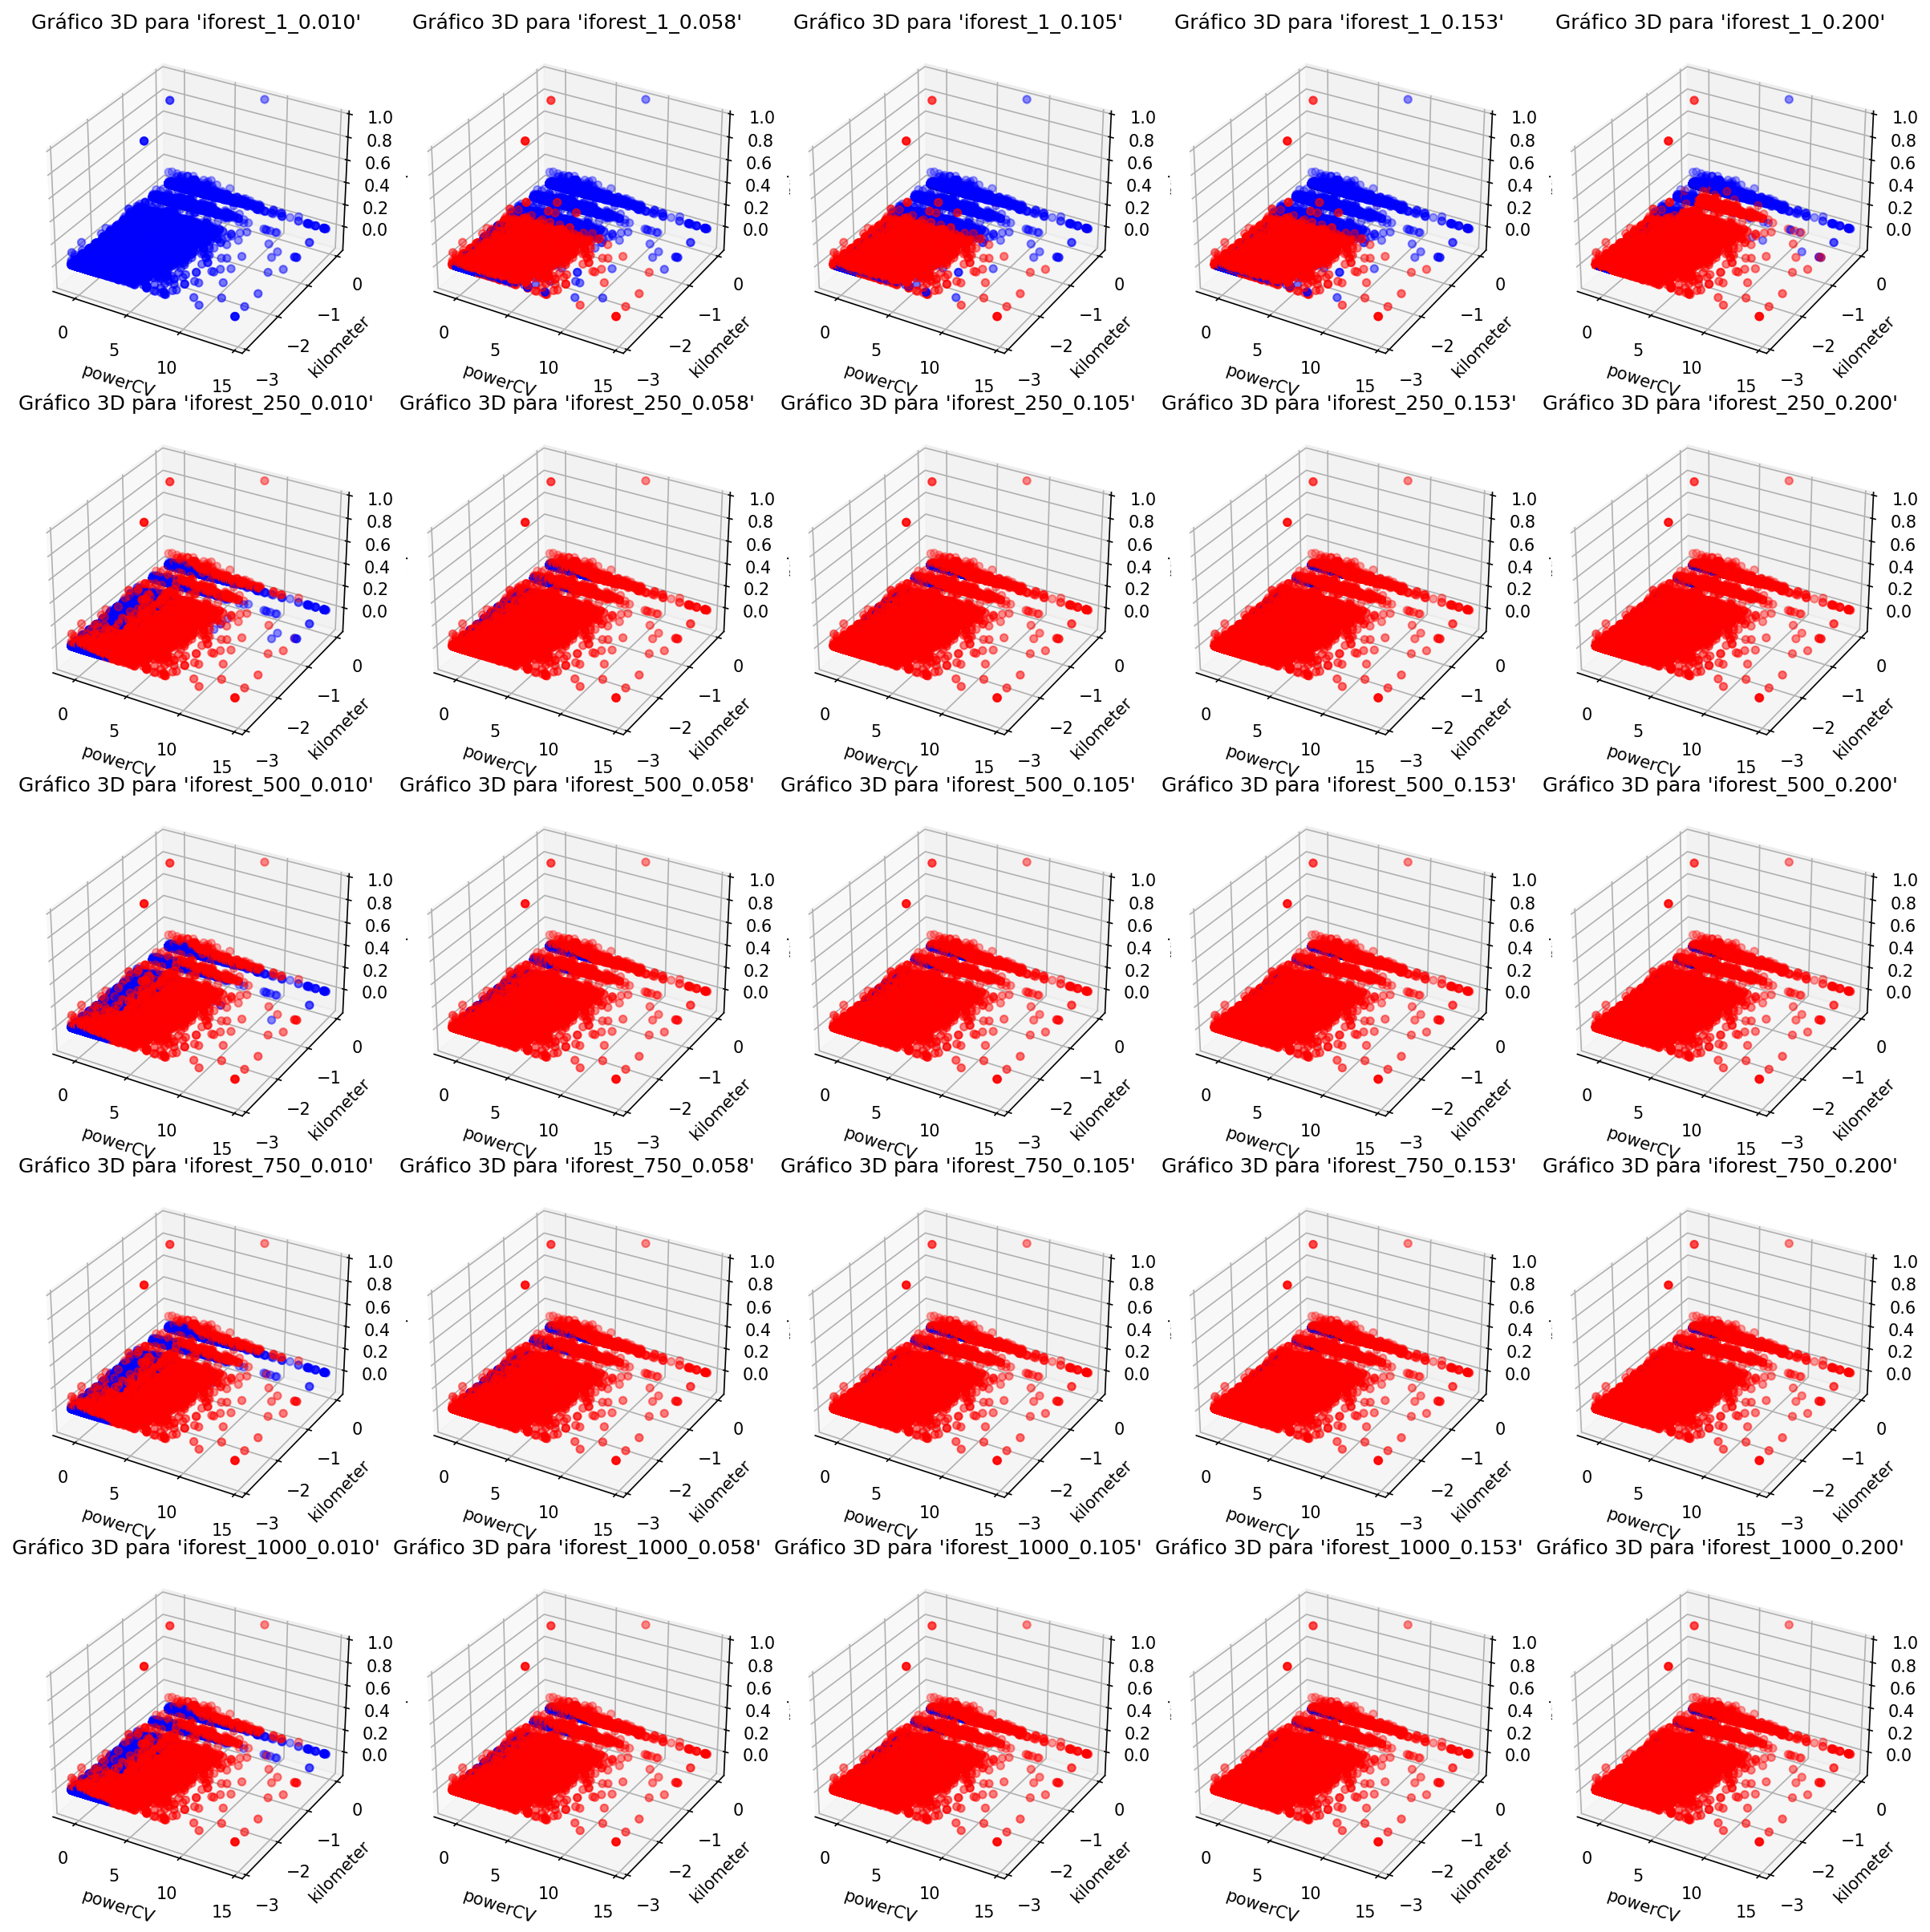

In [9]:
x = df_numeric["powerCV"]
y = df_numeric["kilometer"]
z = df_numeric["price"]

color = {1 : "blue", -1 : "red"}

n_rows = 5
n_cols = 5

fig = plt.figure(figsize=(16, 16), dpi=150)

for idx, col in enumerate(df_forest.columns):
    colors = df_forest[col].map(color) 
    

    ax = fig.add_subplot(n_rows, n_cols, idx + 1, projection='3d')
    ax.scatter(x, y, z, c=colors)
    
    ax.set_title(f"Gráfico 3D para '{col}'")
    ax.set_xlabel("powerCV")
    ax.set_ylabel("kilometer")
    ax.set_zlabel("price")

    ax.set_zlim(top=1e6)
plt.tight_layout()
plt.show()


In [10]:
def percent_outs(array):
    length = len(array)
    neg_count = sum(array==-1)
    p_outs = neg_count/length*100
    return p_outs

Calculemos qué porcentaje de las combinaciones clasifican a cada una de las filas como atípico.

In [11]:
percentages = df_forest.apply(percent_outs, axis=1)

Nos quedaremos con aquellos valores que fueron marcados como atípicos en el 70% de los casos, ya que, teniendo en cuenta de que trabajamos con 25 combinaciones, más del 70% de ellos son al menos 18 combinaciones.

Veamos ahora una comparación de cómo cambian nuestros datos (antes y después de filtrar).

In [12]:
df_filtered_1 = df[percentages<70]

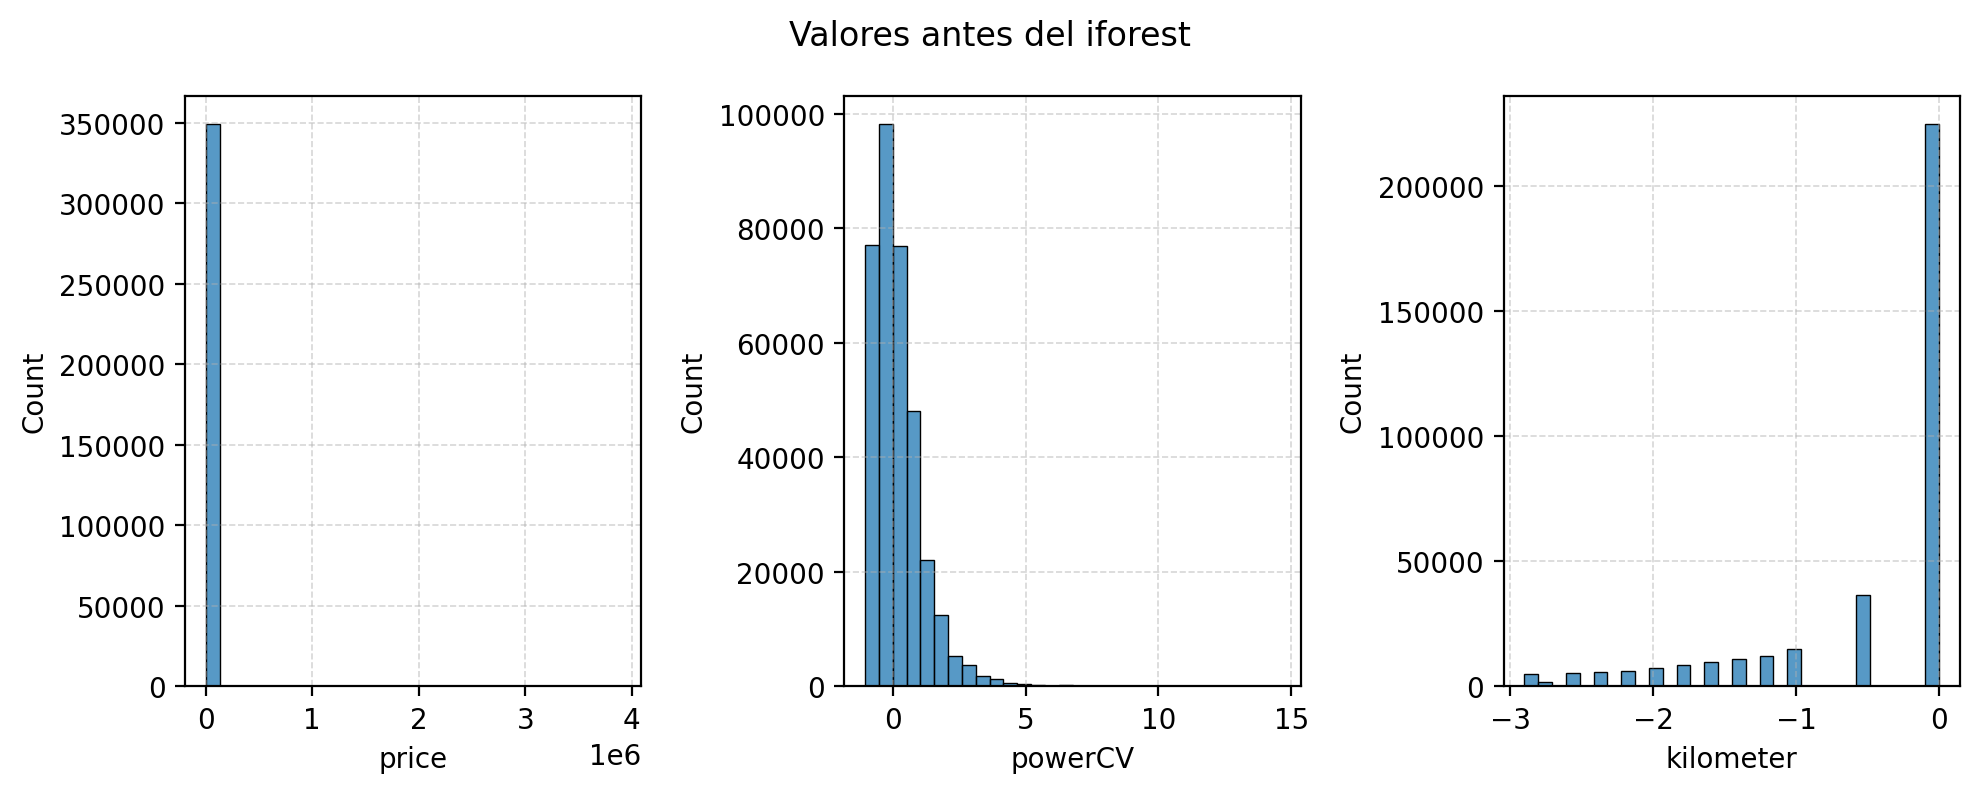

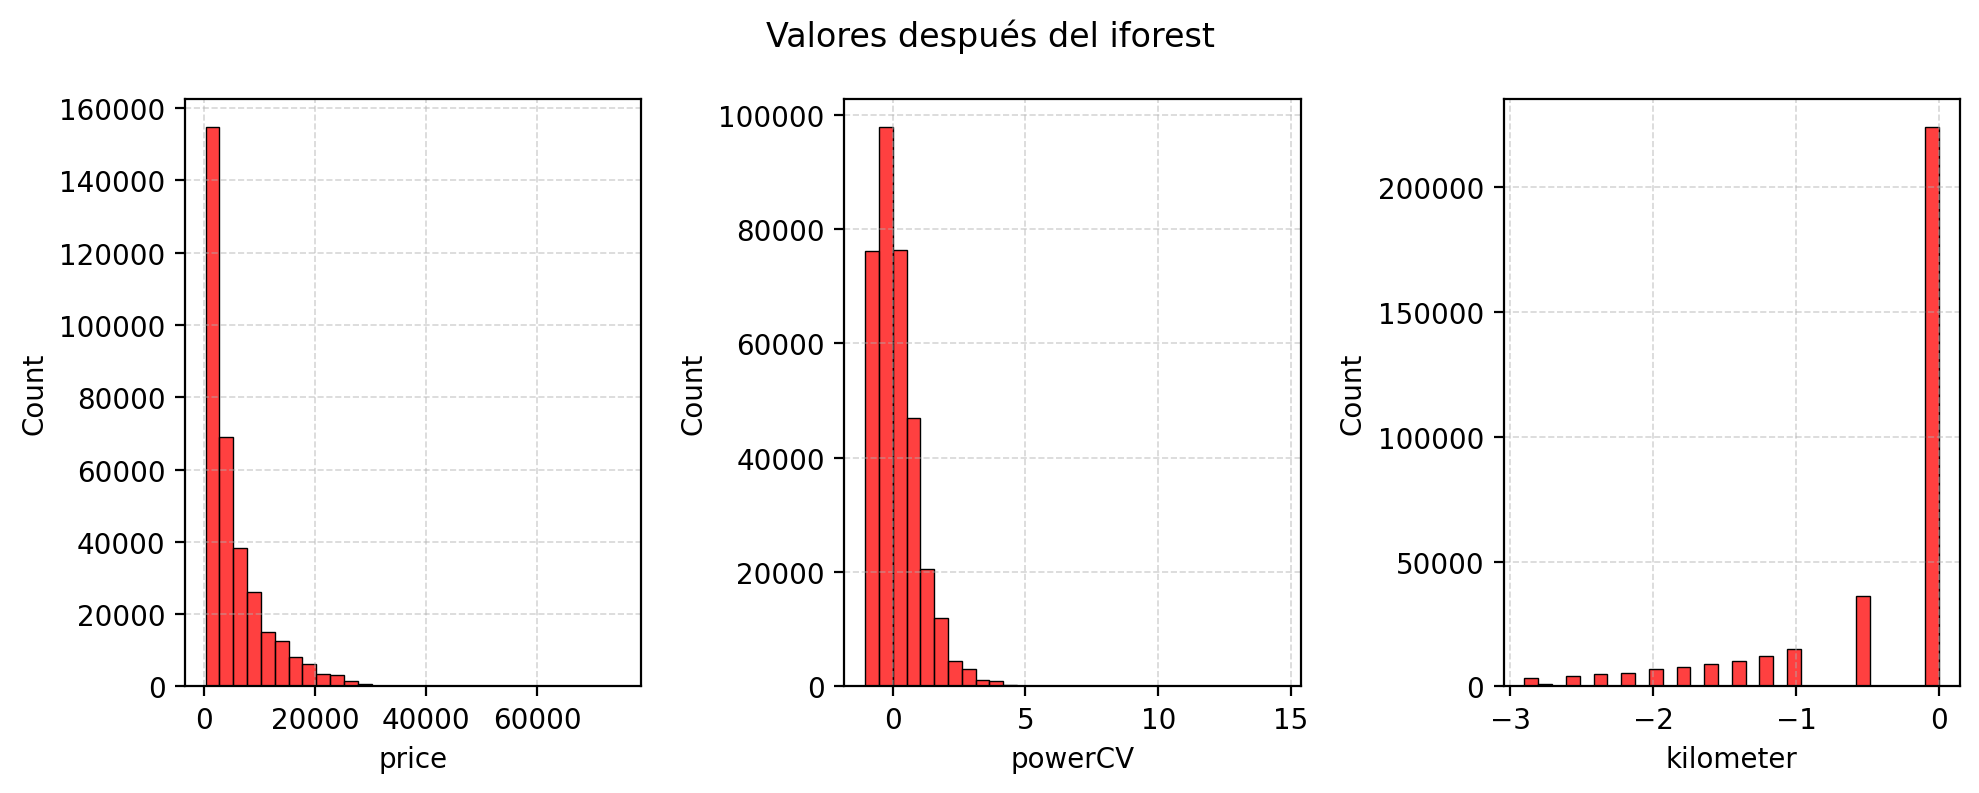

In [13]:
fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(df, x = col, bins = 30, ax = axes[i])
plt.suptitle("Valores antes del iforest")
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(df_filtered_1, x = col, bins = 30, ax = axes[i], color="red")
plt.suptitle("Valores después del iforest")
plt.tight_layout()

plt.show()


Vemos que ahora los precios están mucho más contenidos, habiendo podido filtrar aquellos mucho mayores de 60000, hasta el punto de que sea visible nuestra distribución.

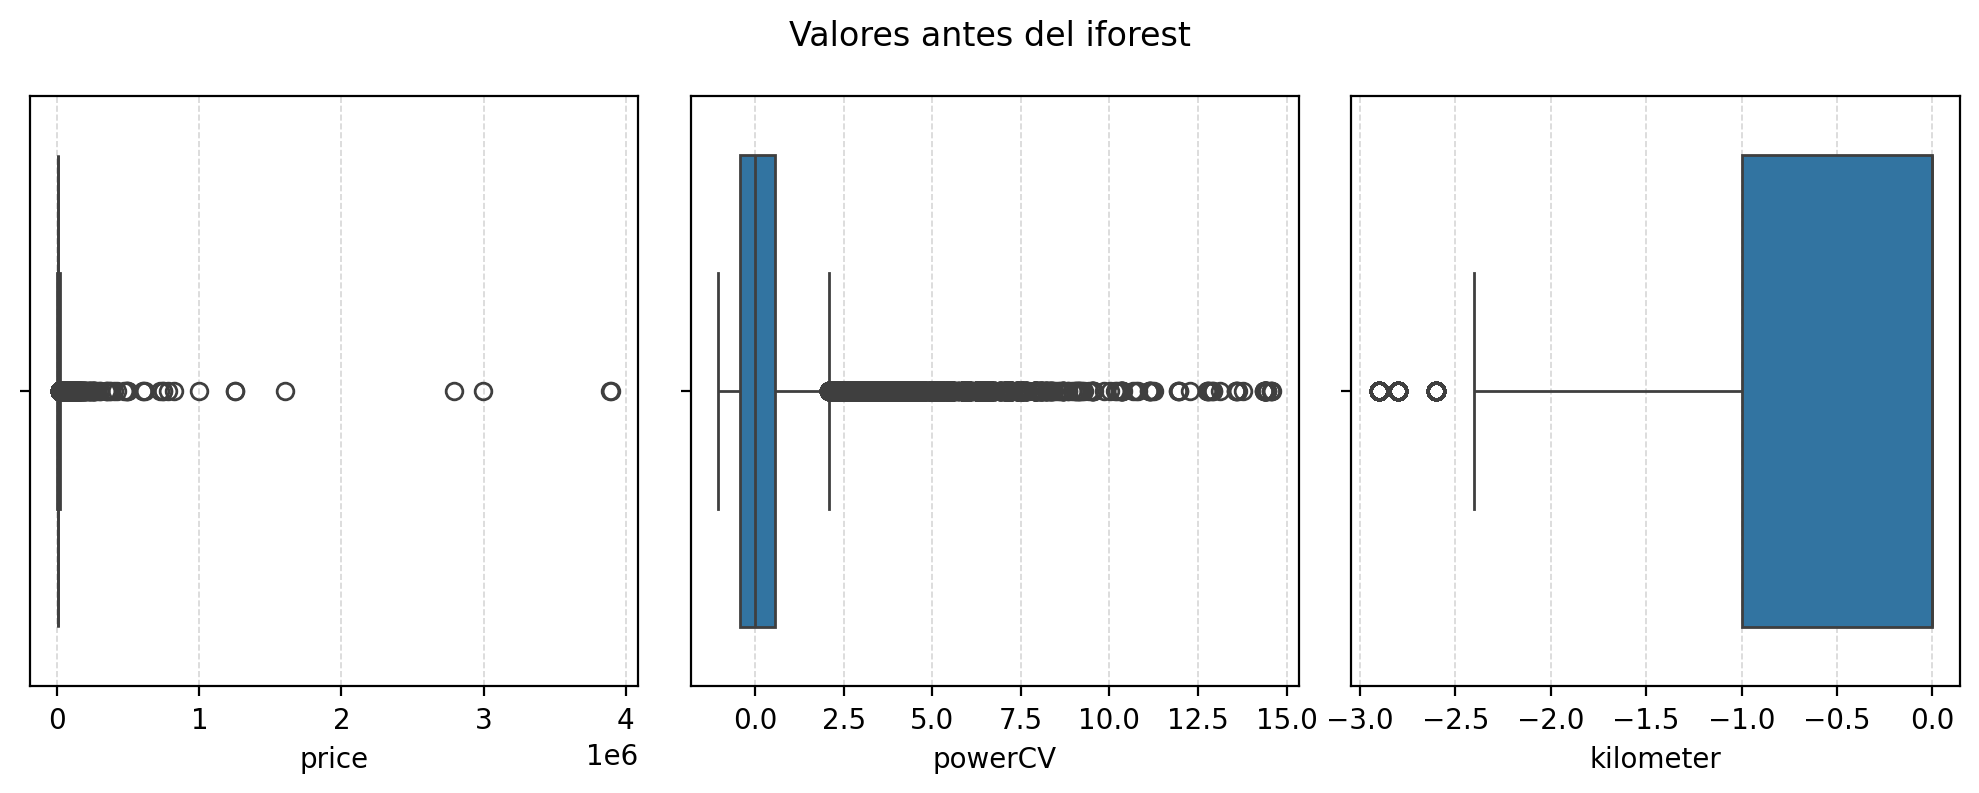

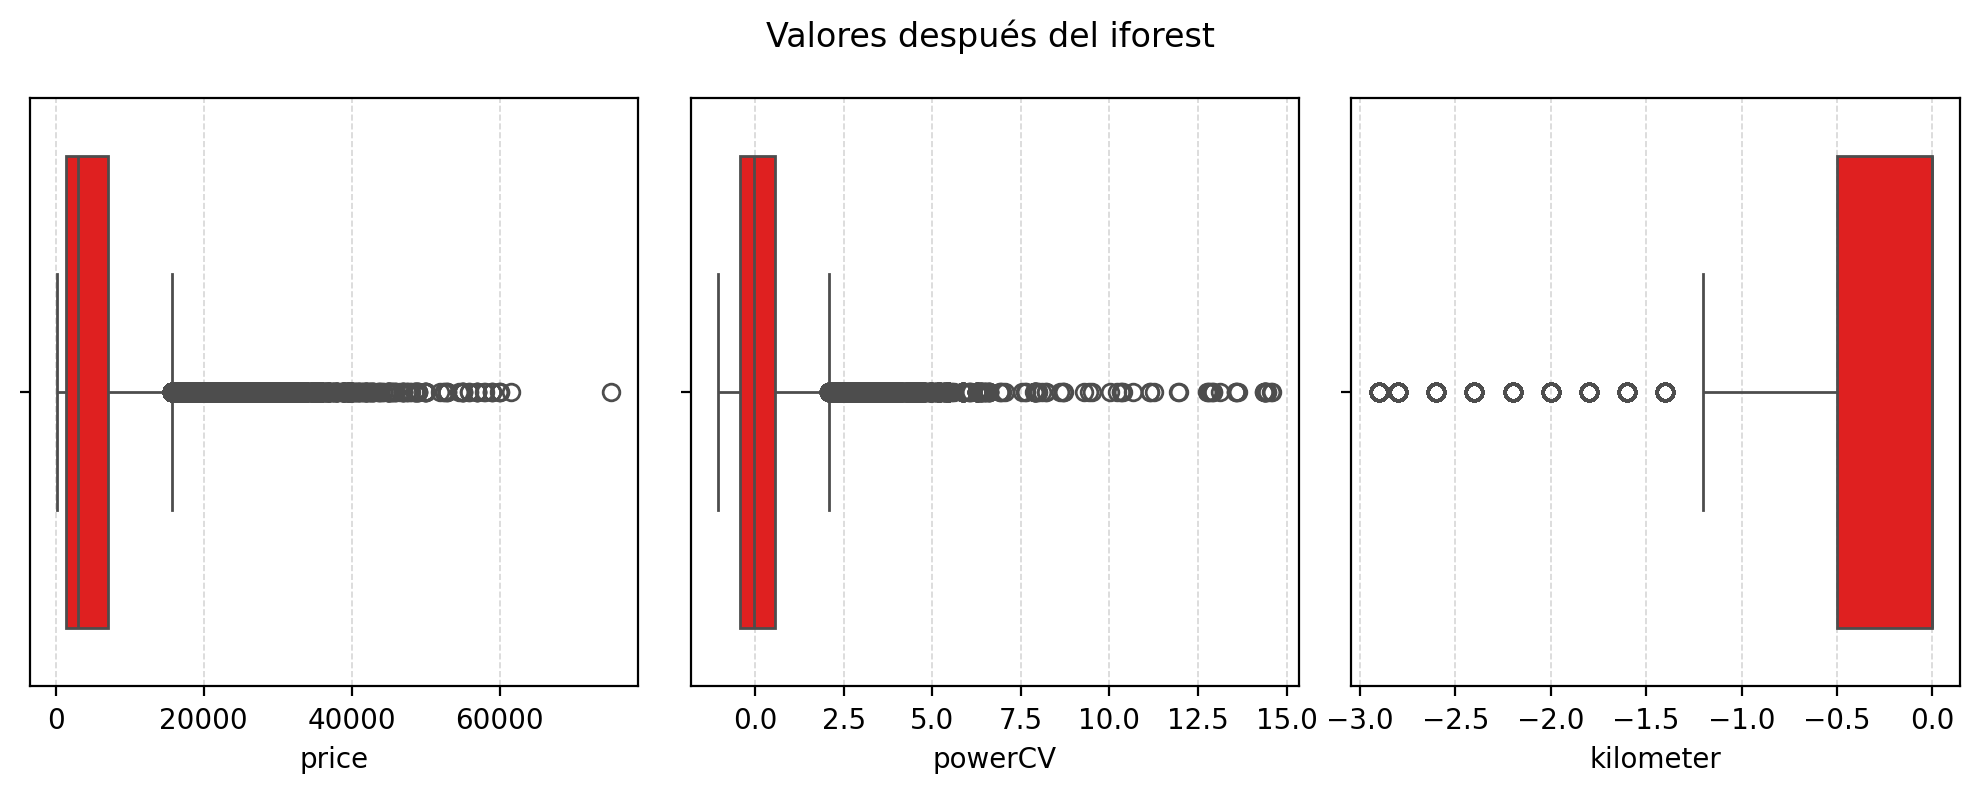

In [14]:
fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.boxplot(df, x = col, ax = axes[i])
plt.suptitle("Valores antes del iforest")
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.boxplot(df_filtered_1, x = col, ax = axes[i], color="red")
plt.suptitle("Valores después del iforest")
plt.tight_layout()

plt.show()


En el caso del boxplot vemos el mismo efecto que el histograma. Vemos que aún seguimos teniendo outliers (los que son menos atípicos), los cuales serán tratados en el segundo paso de nuestro proceso: usando Local Outlier Factor (LOF). Algo a remarcar es la variable `kilometer`, la la cual parece que aumenta su número de outliers. Lo que sucede es que nuestro algoritmo IFO ha clasificado, con la vista general, a algunos valores localizados en el bigote izquierdo como outlier, haciendo que el Q1 se desplace a la derecha, y por ende, reduciendo el IQR y el rango de valores no atípicos.

In [15]:
df_filtered_1 = df_filtered_1.drop(columns = df_filtered_1.filter(like="iforest").columns)

In [16]:
df_numeric_filtered_1 = df_filtered_1.select_dtypes("number")

In [17]:
neighs = np.linspace(15,45,5, dtype=int)
lof_combis = list(product(neighs, conts))

In [18]:
for neighbour, contaminacion in tqdm(lof_combis):
    print(f"Creando lof_{neighbour}_{contaminacion}")
    lof = LocalOutlierFactor(n_neighbors=neighbour, contamination=contaminacion, n_jobs=-1)
    df_filtered_1[f"lof_{neighbour}_{contaminacion:.3f}"] = lof.fit_predict(X = df_numeric_filtered_1)

  0%|          | 0/25 [00:00<?, ?it/s]

Creando lof_15_0.01


  4%|▍         | 1/25 [00:04<01:39,  4.13s/it]

Creando lof_15_0.0575


  8%|▊         | 2/25 [00:08<01:34,  4.12s/it]

Creando lof_15_0.105


 12%|█▏        | 3/25 [00:13<01:42,  4.65s/it]

Creando lof_15_0.15250000000000002


 16%|█▌        | 4/25 [00:20<01:57,  5.59s/it]

Creando lof_15_0.2


 20%|██        | 5/25 [00:26<01:56,  5.85s/it]

Creando lof_22_0.01


 24%|██▍       | 6/25 [00:32<01:52,  5.91s/it]

Creando lof_22_0.0575


 28%|██▊       | 7/25 [00:40<01:57,  6.54s/it]

Creando lof_22_0.105


 32%|███▏      | 8/25 [00:49<02:01,  7.15s/it]

Creando lof_22_0.15250000000000002


 36%|███▌      | 9/25 [00:56<01:56,  7.26s/it]

Creando lof_22_0.2


 40%|████      | 10/25 [01:03<01:47,  7.14s/it]

Creando lof_30_0.01


 44%|████▍     | 11/25 [01:11<01:44,  7.47s/it]

Creando lof_30_0.0575


 48%|████▊     | 12/25 [01:19<01:36,  7.43s/it]

Creando lof_30_0.105


 52%|█████▏    | 13/25 [01:27<01:32,  7.73s/it]

Creando lof_30_0.15250000000000002


 56%|█████▌    | 14/25 [01:34<01:22,  7.51s/it]

Creando lof_30_0.2


 60%|██████    | 15/25 [01:41<01:13,  7.35s/it]

Creando lof_37_0.01


 64%|██████▍   | 16/25 [01:48<01:05,  7.26s/it]

Creando lof_37_0.0575


 68%|██████▊   | 17/25 [01:55<00:56,  7.02s/it]

Creando lof_37_0.105


 72%|███████▏  | 18/25 [02:03<00:52,  7.55s/it]

Creando lof_37_0.15250000000000002


 76%|███████▌  | 19/25 [02:12<00:48,  8.04s/it]

Creando lof_37_0.2


 80%|████████  | 20/25 [02:21<00:41,  8.27s/it]

Creando lof_45_0.01


 84%|████████▍ | 21/25 [02:31<00:34,  8.64s/it]

Creando lof_45_0.0575


 88%|████████▊ | 22/25 [02:40<00:26,  8.84s/it]

Creando lof_45_0.105


 92%|█████████▏| 23/25 [02:49<00:17,  8.95s/it]

Creando lof_45_0.15250000000000002


 96%|█████████▌| 24/25 [02:58<00:08,  8.96s/it]

Creando lof_45_0.2


100%|██████████| 25/25 [03:07<00:00,  7.51s/it]


In [19]:
df_lof = df_filtered_1.filter(like="lof")

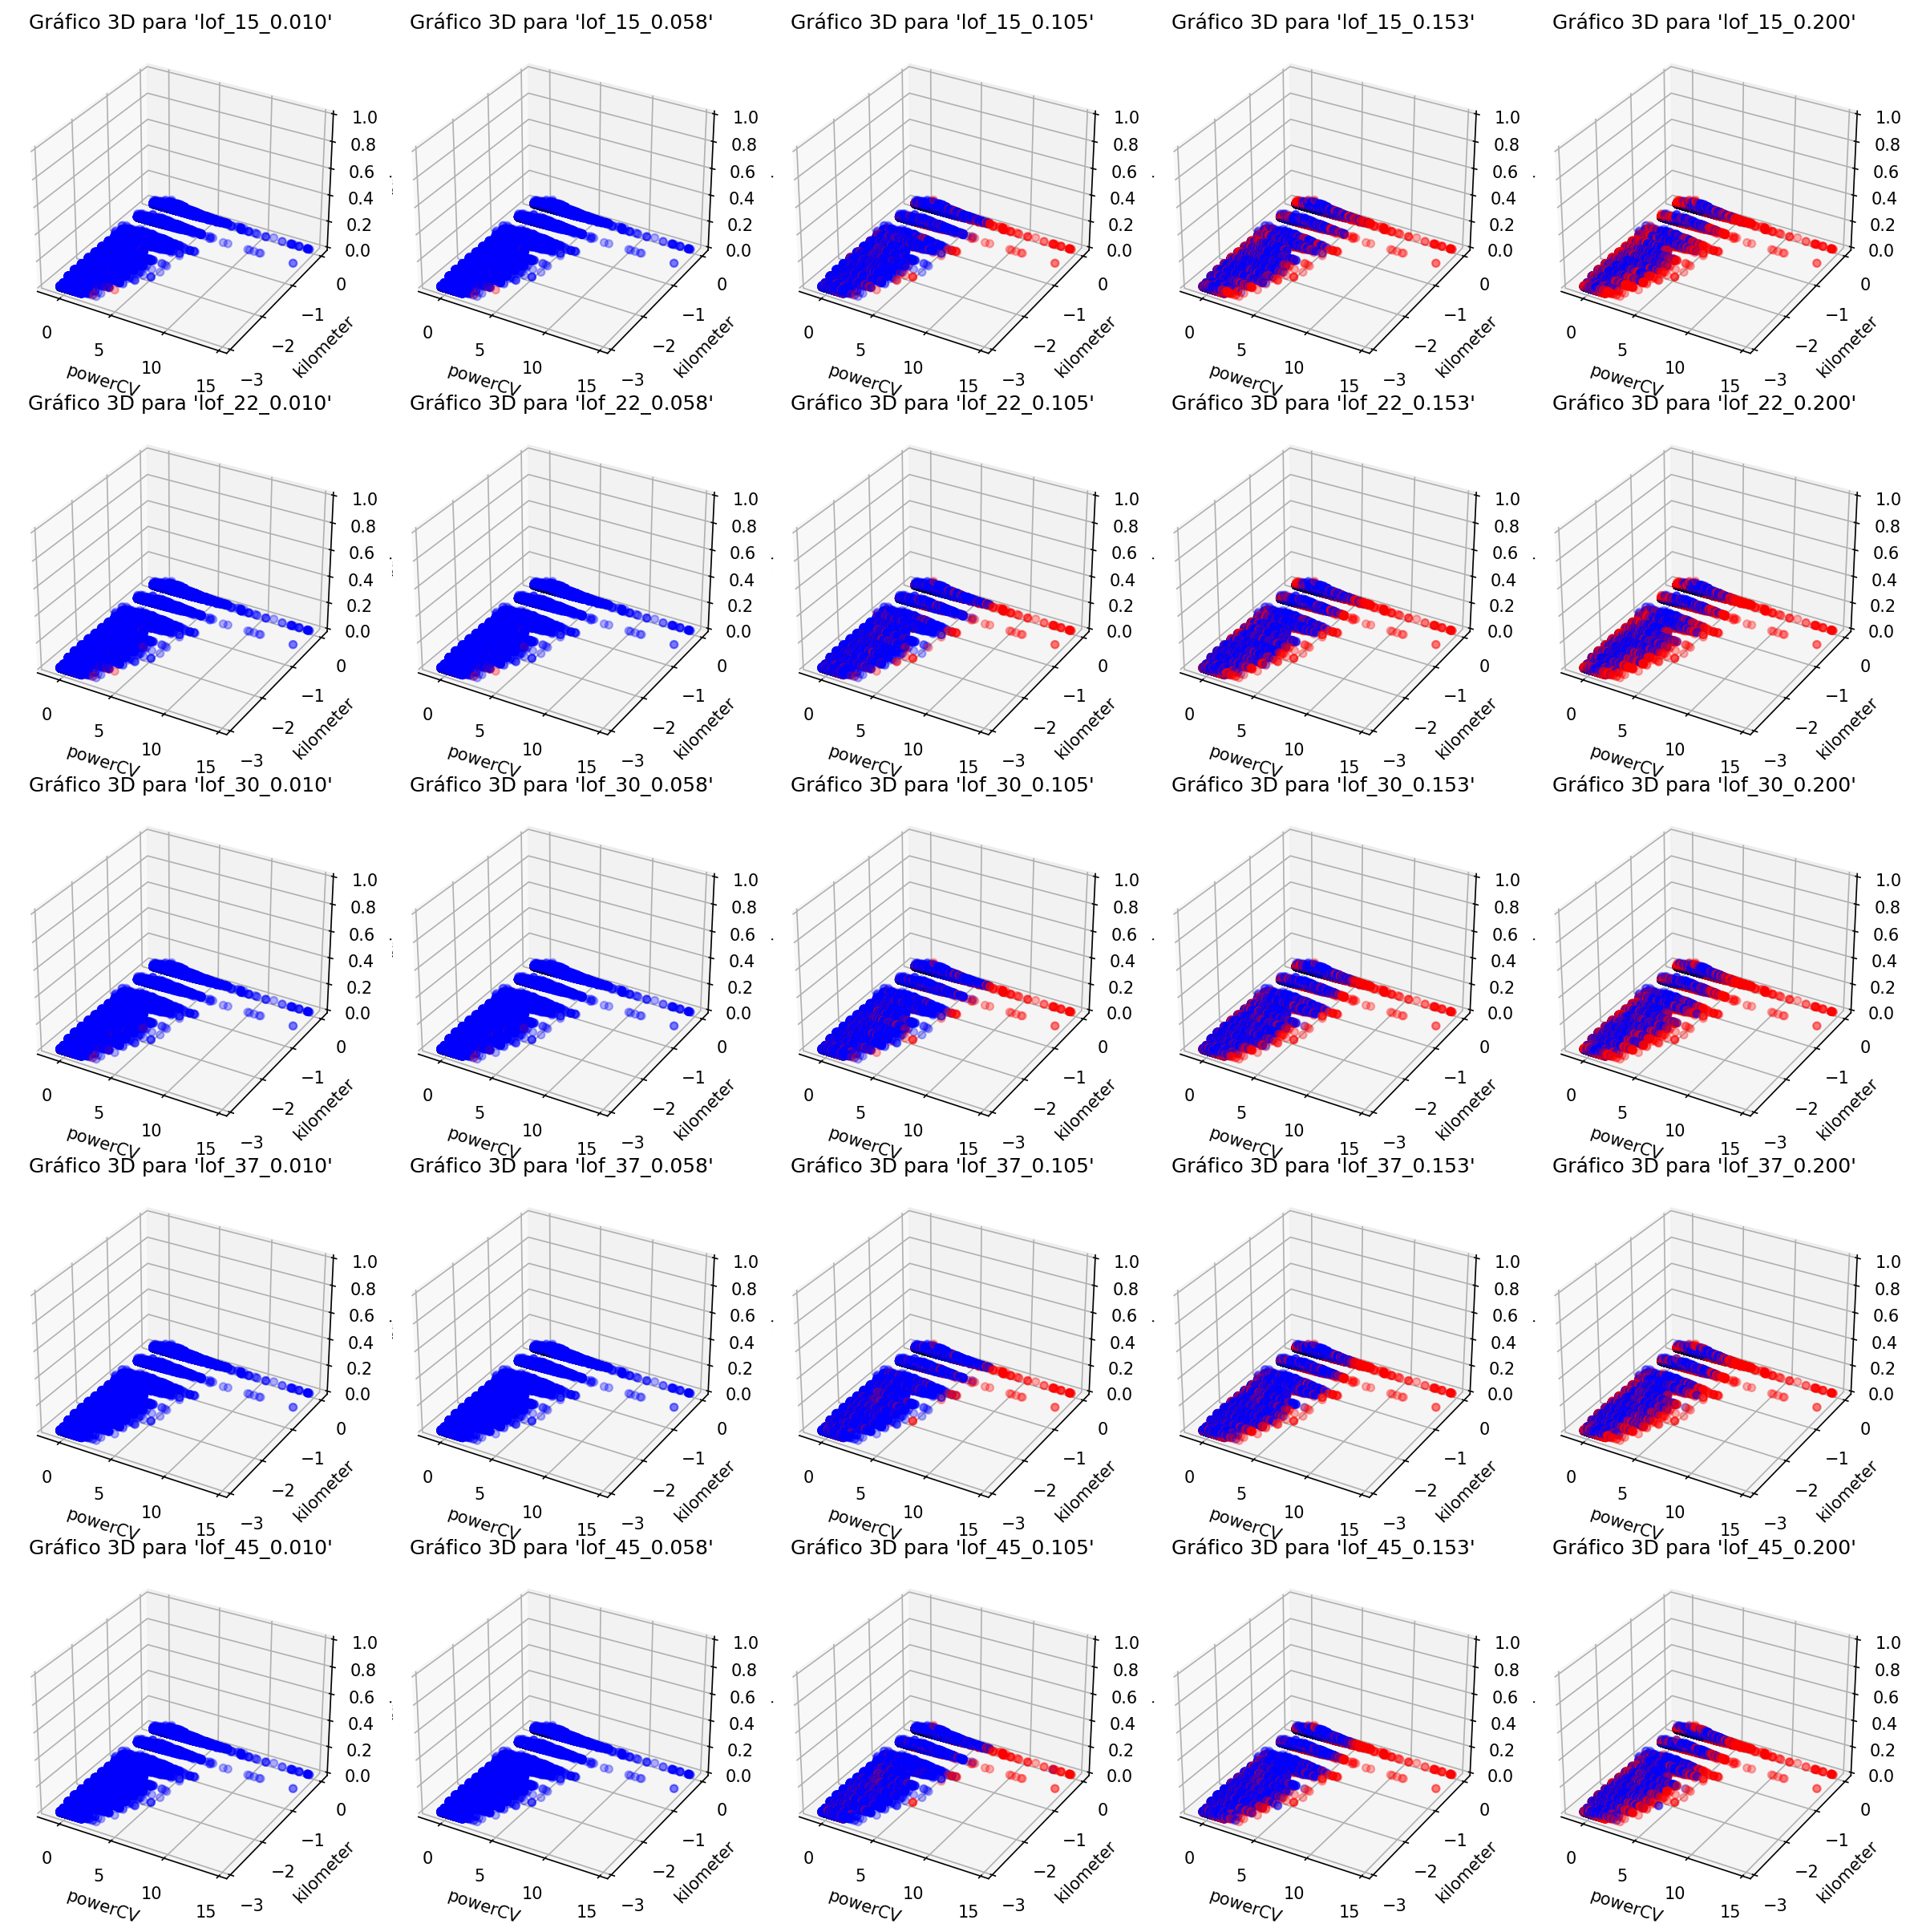

In [20]:
x = df_numeric_filtered_1["powerCV"]
y = df_numeric_filtered_1["kilometer"]
z = df_numeric_filtered_1["price"]

color = {1 : "blue", -1 : "red"}

n_rows = 5
n_cols = 5

fig = plt.figure(figsize=(16, 16), dpi=150)

for idx, col in enumerate(df_lof.columns):
    colors = df_lof[col].map(color) 
    

    ax = fig.add_subplot(n_rows, n_cols, idx + 1, projection='3d')
    ax.scatter(x, y, z, c=colors, alpha = 0.3)
    
    ax.set_title(f"Gráfico 3D para '{col}'")
    ax.set_xlabel("powerCV")
    ax.set_ylabel("kilometer")
    ax.set_zlabel("price")

    ax.set_zlim(top=1e6)
plt.tight_layout()
plt.show()


Vamos a observar los valores de

In [21]:
percentages_filter_1 = df_lof.apply(percent_outs, axis=1)

In [22]:
outliers = df_filtered_1[percentages_filter_1>70]
normals = df_filtered_1[percentages_filter_1<70]

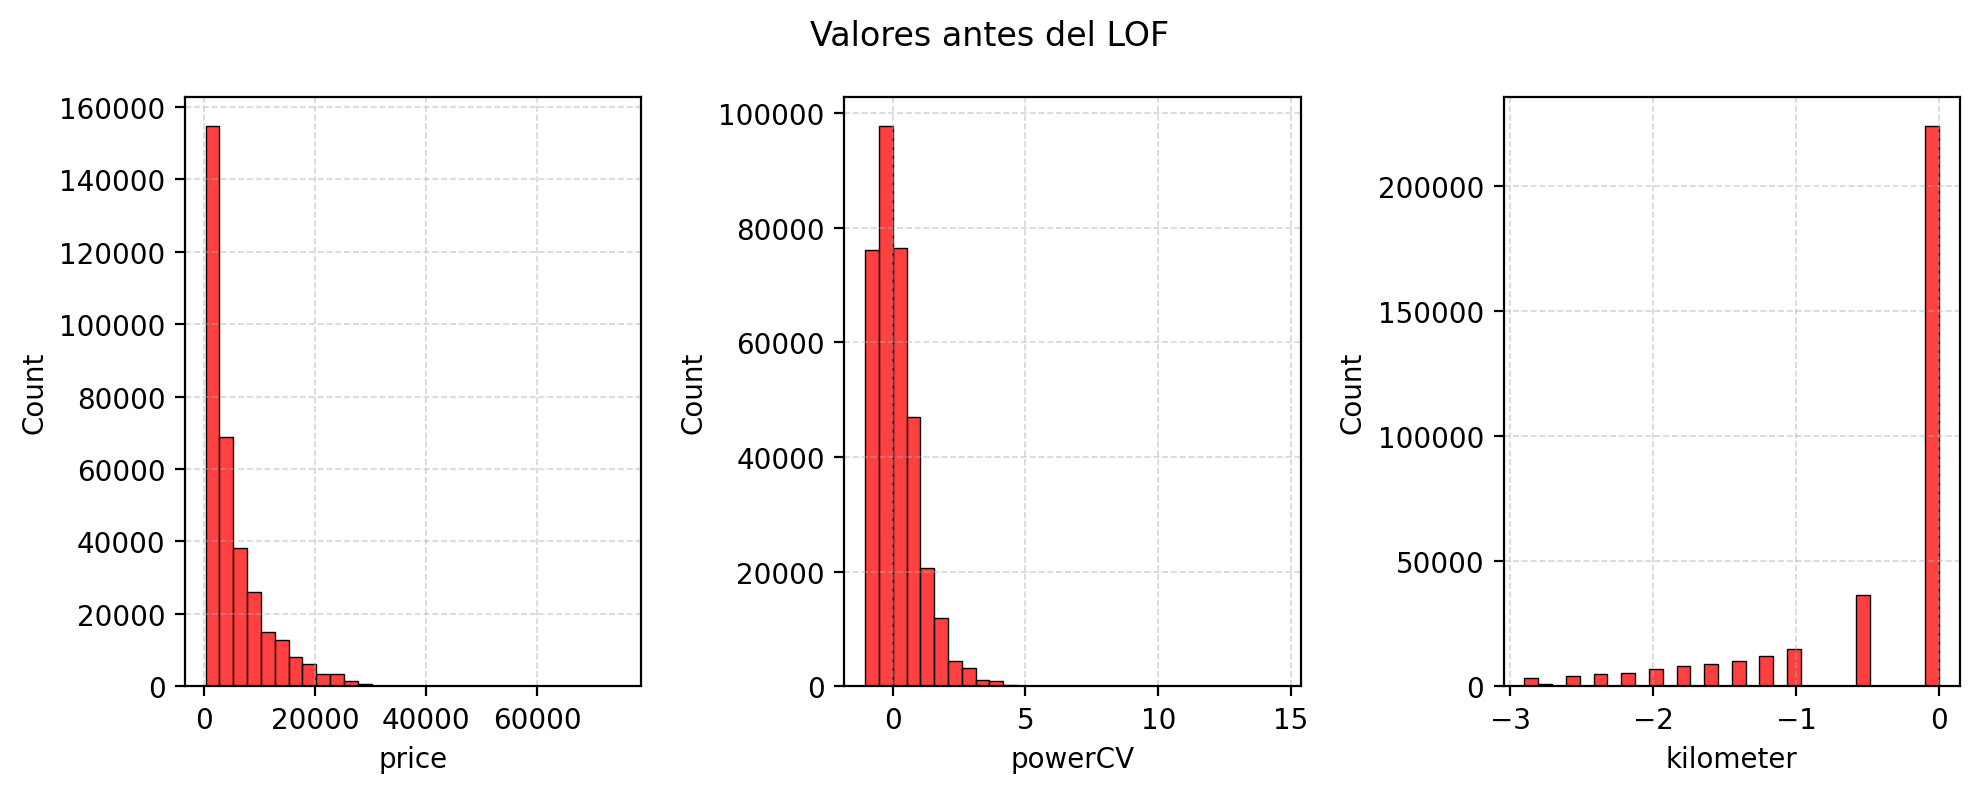

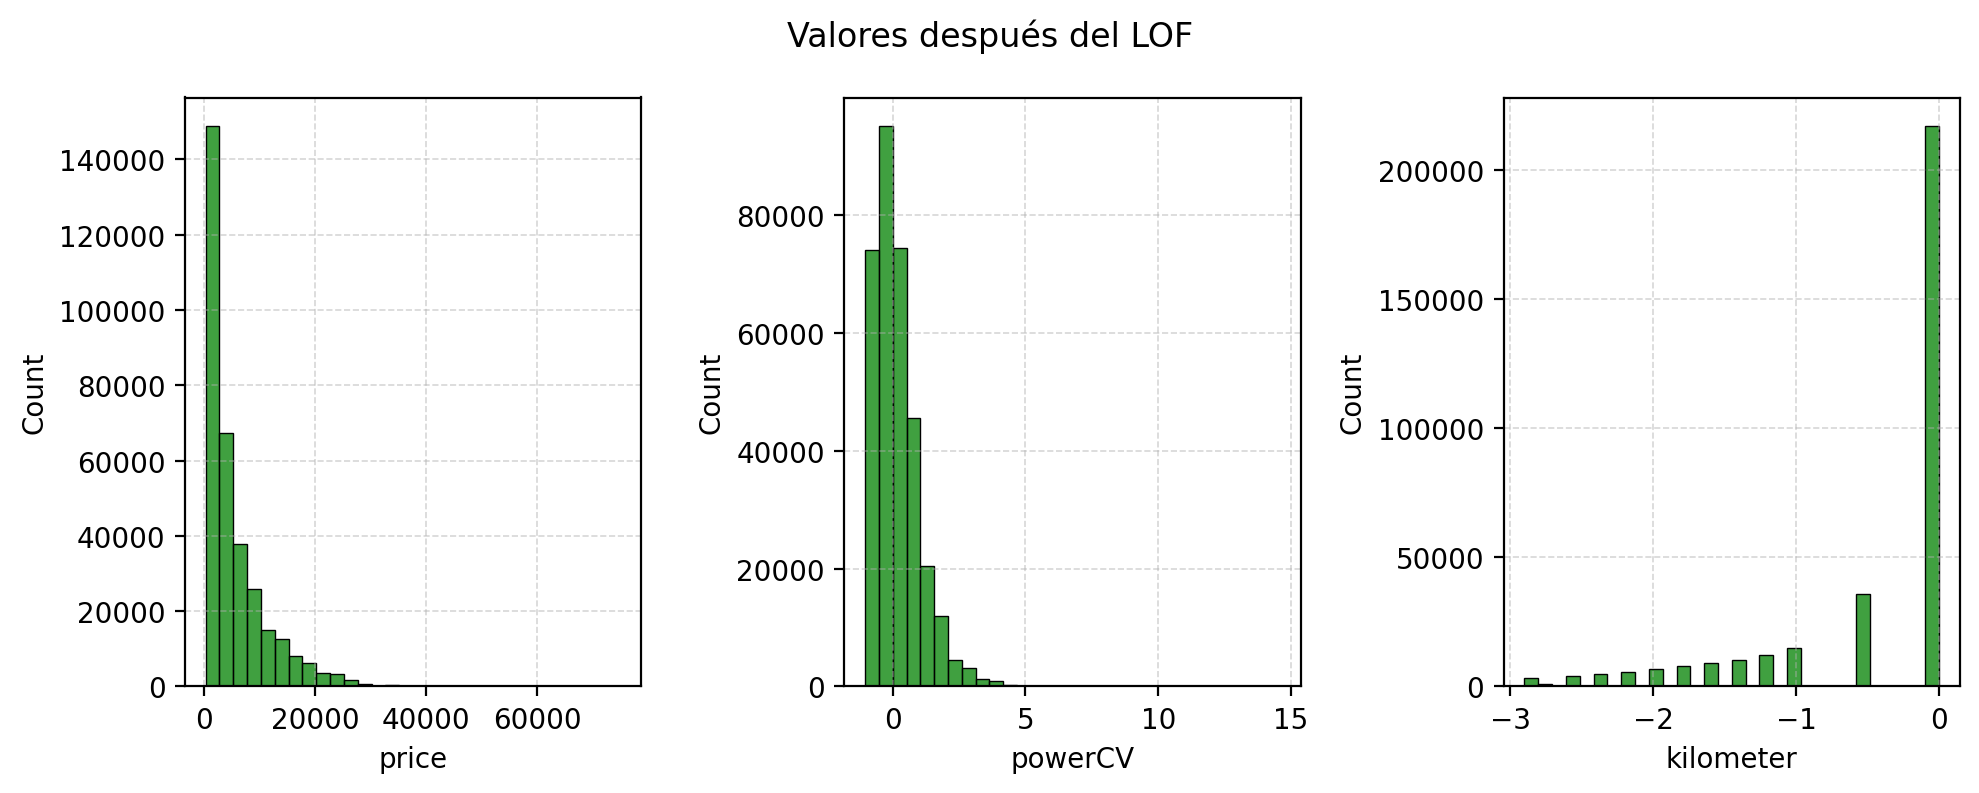

In [23]:
fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(df_filtered_1, x = col, bins = 30, ax = axes[i], color="red")
plt.suptitle("Valores antes del LOF")
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(normals, x = col, bins = 30,  ax= axes[i], color="green")
plt.suptitle("Valores después del LOF")
plt.tight_layout()

plt.show()


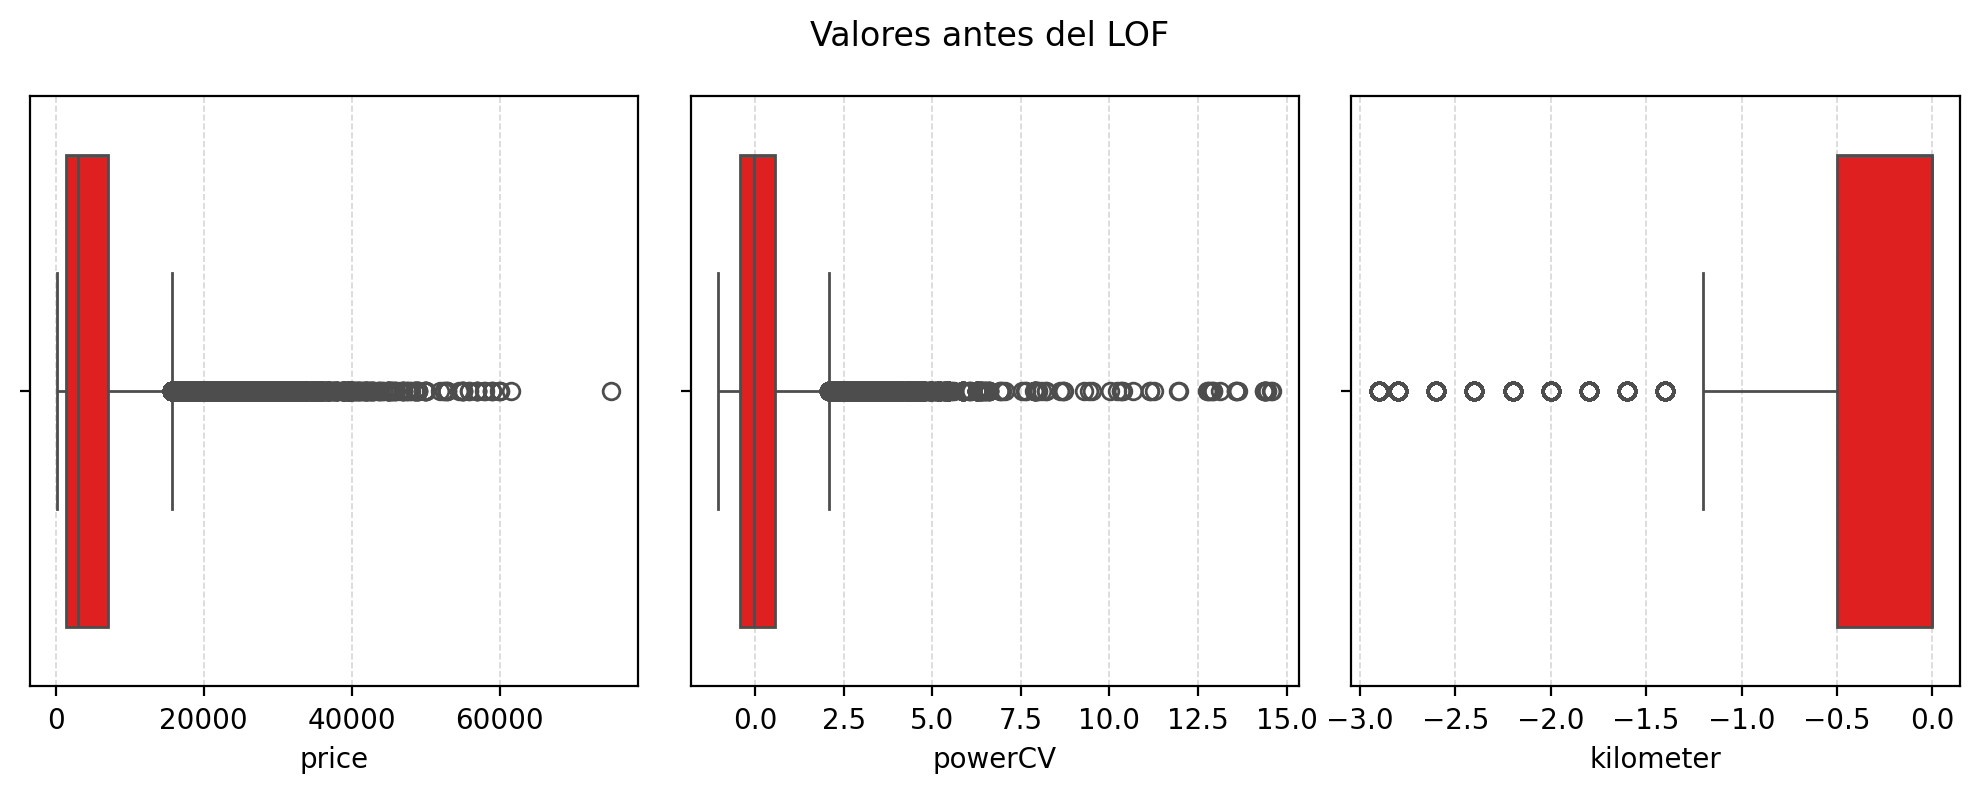

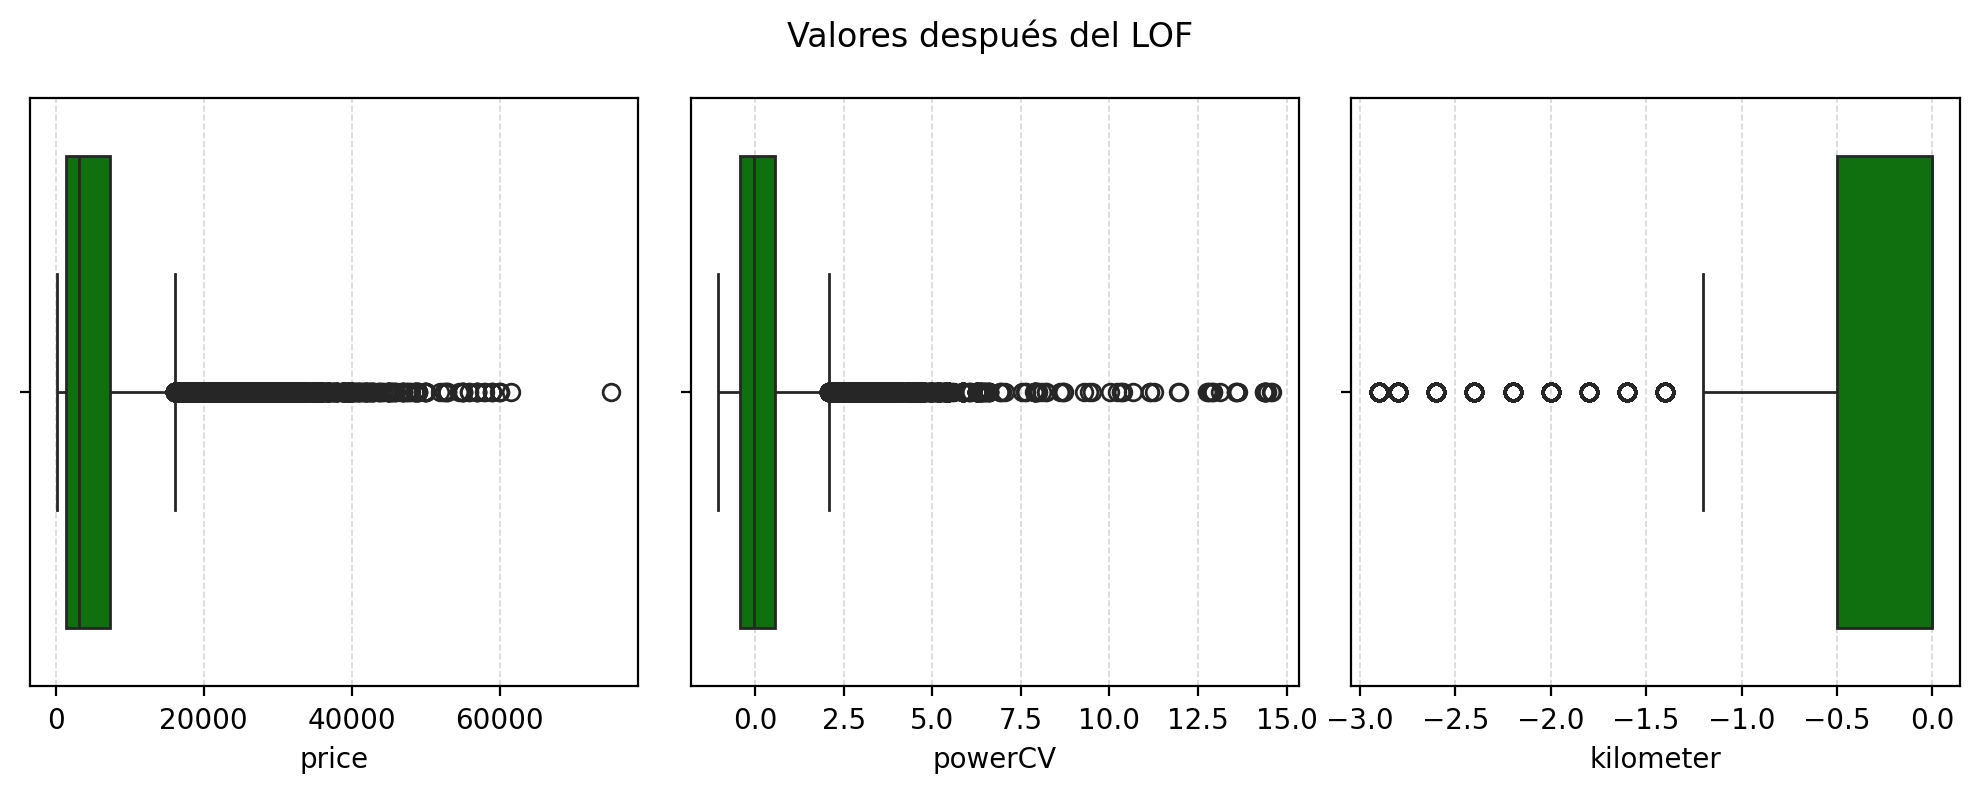

In [24]:
fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.boxplot(df_filtered_1, x = col, ax = axes[i], color="red")
plt.suptitle("Valores antes del LOF")
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.boxplot(normals, x = col,  ax= axes[i], color="green")
plt.suptitle("Valores después del LOF")
plt.tight_layout()

plt.show()


Vemos que no hay diferencias muy claras entre los valores originales con los que obtendríamos si eliminaramos los outliers producidos por el método. Sin embargo, debemos conocer un poco mejor nuestros datos antes de tomar medidas de este tipo.

In [25]:
normal_cat = df_filtered_1.drop(index=outliers.index).select_dtypes('O')
normal_num = df_filtered_1.drop(index=outliers.index).drop(columns = df_lof.columns).select_dtypes('number')
normal_cat_describe = normal_cat.describe().T
normal_num_describe =normal_num.describe().T

outliers_cat = df_filtered_1.loc[outliers.index]
outliers_num = df_filtered_1.loc[outliers.index].drop(columns = df_lof.columns).select_dtypes('number')
outliers_cat_describe = outliers_cat.select_dtypes('O').describe().T
outliers_num_describe = outliers_num.describe().T

In [26]:
display(pd.concat([normal_cat_describe,outliers_cat_describe], axis= 1))
print('----------------------------------------------------------------')
display(pd.concat([normal_num_describe,outliers_num_describe], axis= 0))

count  unique                  top    freq count unique  \
dateCrawled          331911  258430  2016-03-24 14:49:47       7  8186   8142   
name                 331911  205336  Volkswagen_Golf_1.4     600  8186   6922   
seller               331911       2              private  331909  8186      1   
offerType            331911       2                offer  331906  8186      1   
abtest               331911       2                 test  172033  8186      2   
vehicleType          331911       8              unknown  117562  8186      8   
yearOfRegistration   331911       6        Coche Moderno  270783  8186      6   
gearbox              331911       3             manually  248711  8186      3   
model                331911     251                 golf   27440  8186    209   
monthOfRegistration  331911      13                march   32898  8186     13   
fuelType             331911       8               petrol  200060  8186      7   
brand                331911      40           volkswagen   72208  8186     40   
notRepairedDamage    331911       3                   no  243830  8186      3   
dateCreated          331911     112           2016-04-03   13028  8186     43   
postalCode           331911    8131                10115     788  8186   3739   
lastSeen             331911  167797  2016-04-07 09:15:43      16  8186   7883   

                                     top  freq  
dateCrawled          2016-03-28 13:38:53     2  
name                            BMW_318i    82  
seller                           private  8186  
offerType                          offer  8186  
abtest                              test  4175  
vehicleType                      unknown  2931  
yearOfRegistration         Coche Moderno  7151  
gearbox                         manually  6743  
model                             andere  1097  
monthOfRegistration                march   835  
fuelType                          petrol  5326  
brand                         volkswagen  1204  
notRepairedDamage                     no  5350  
dateCreated                   2016-03-14   312  
postalCode                         42105    20  
lastSeen             2016-04-05 18:18:38     3

----------------------------------------------------------------


count         mean          std         min          25%  \
price      331911.0  5338.692351  5659.483522  251.000000  1370.000000   
powerCV    331911.0     0.157710     0.867546   -1.037674    -0.428246   
kilometer  331911.0    -0.451049     0.747733   -2.900000    -0.500000   
price        8186.0  2334.487906  2071.909955  279.000000   900.000000   
powerCV      8186.0    -0.062411     0.543285   -1.037674    -0.527072   
kilometer    8186.0    -0.164390     0.569149   -2.900000     0.000000   

                   50%          75%           max  
price      3200.000000  7300.000000  75000.000000  
powerCV      -0.016471     0.576485     14.576845  
kilometer     0.000000     0.000000      0.000000  
price      1700.000000  2990.000000  19999.000000  
powerCV      -0.092307     0.345891      3.113021  
kilometer     0.000000     0.000000      0.000000

Observando los categóricos, no vemos diferencias muy grandes, lo cual es esperable ya que no se consideraron para la identificación de los valores atípicos. En cuanto a los numéricos, vemos que los precios de los atípicos son más bajos que en los datos normales. Para decidir qué hacer con estos outliers, una opción podría ser ver si hay diferencias significativas entre las distribuciones de ambos lados, usando un contraste de hipótesis.

No son distribuciones normales, usaremos no paramétricos directamente, concretamente el test de Mann-Whitney, al tratarse de pares de muestras independientes.

In [27]:
import scipy.stats as stats

for col in outliers_num.columns:
    print(col)
    print(stats.mannwhitneyu(normal_num[col], outliers_num[col]))
    print()

price
MannwhitneyuResult(statistic=1821579444.5, pvalue=0.0)

powerCV
MannwhitneyuResult(statistic=1502688021.5, pvalue=1.0545973670311414e-60)

kilometer
MannwhitneyuResult(statistic=1061302374.0, pvalue=0.0)



Ninguna de las distribuciones son similares a las distribuciones de los datos no atípicos, por lo que optaremos por imputar los valores de powerCV y kilometers (no price porque es variable respuesta). Vamos a usar un RandomForest.

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [29]:
df_filtered_1.loc[outliers.index, "powerCV"] = np.nan
df_filtered_1.loc[outliers.index, "kilometer"] = np.nan

In [30]:
df_filtered_1.reset_index(drop=True, inplace=True)

In [31]:
imputer = IterativeImputer(estimator=RandomForestRegressor())
imputed_cols = pd.DataFrame(imputer.fit_transform(X=df_filtered_1[["price", "powerCV", "kilometer"]]), columns = ["price", "powerCV", "kilometer"])

In [32]:
df_final = df_filtered_1.drop(columns = df_filtered_1.filter(like="lof").columns)
df_final[["price", "powerCV", "kilometer"]] = imputed_cols

In [33]:
df_final.describe().T

count         mean          std         min          25%  \
price      340097.0  5266.382341  5619.086035  251.000000  1350.000000   
powerCV    340097.0     0.144226     0.862758   -1.037674    -0.448323   
kilometer  340097.0    -0.461260     0.745654   -2.900000    -0.514333   

                   50%          75%           max  
price      3100.000000  7100.000000  75000.000000  
powerCV      -0.065884     0.576485     14.576845  
kilometer     0.000000     0.000000      0.000000

In [34]:
df_filtered_1.drop(columns = df_filtered_1.filter(like="lof").columns).describe().T

count         mean          std         min          25%  \
price      340097.0  5266.382341  5619.086035  251.000000  1350.000000   
powerCV    331911.0     0.157710     0.867546   -1.037674    -0.428246   
kilometer  331911.0    -0.451049     0.747733   -2.900000    -0.500000   

                   50%          75%           max  
price      3100.000000  7100.000000  75000.000000  
powerCV      -0.016471     0.576485     14.576845  
kilometer     0.000000     0.000000      0.000000

Vemos que los valores en general no varían mucho de los originales, lo cual es esperable dado que no representaban ni un 3% de éstos. Podemos visualizarlo también con las distribuciones:

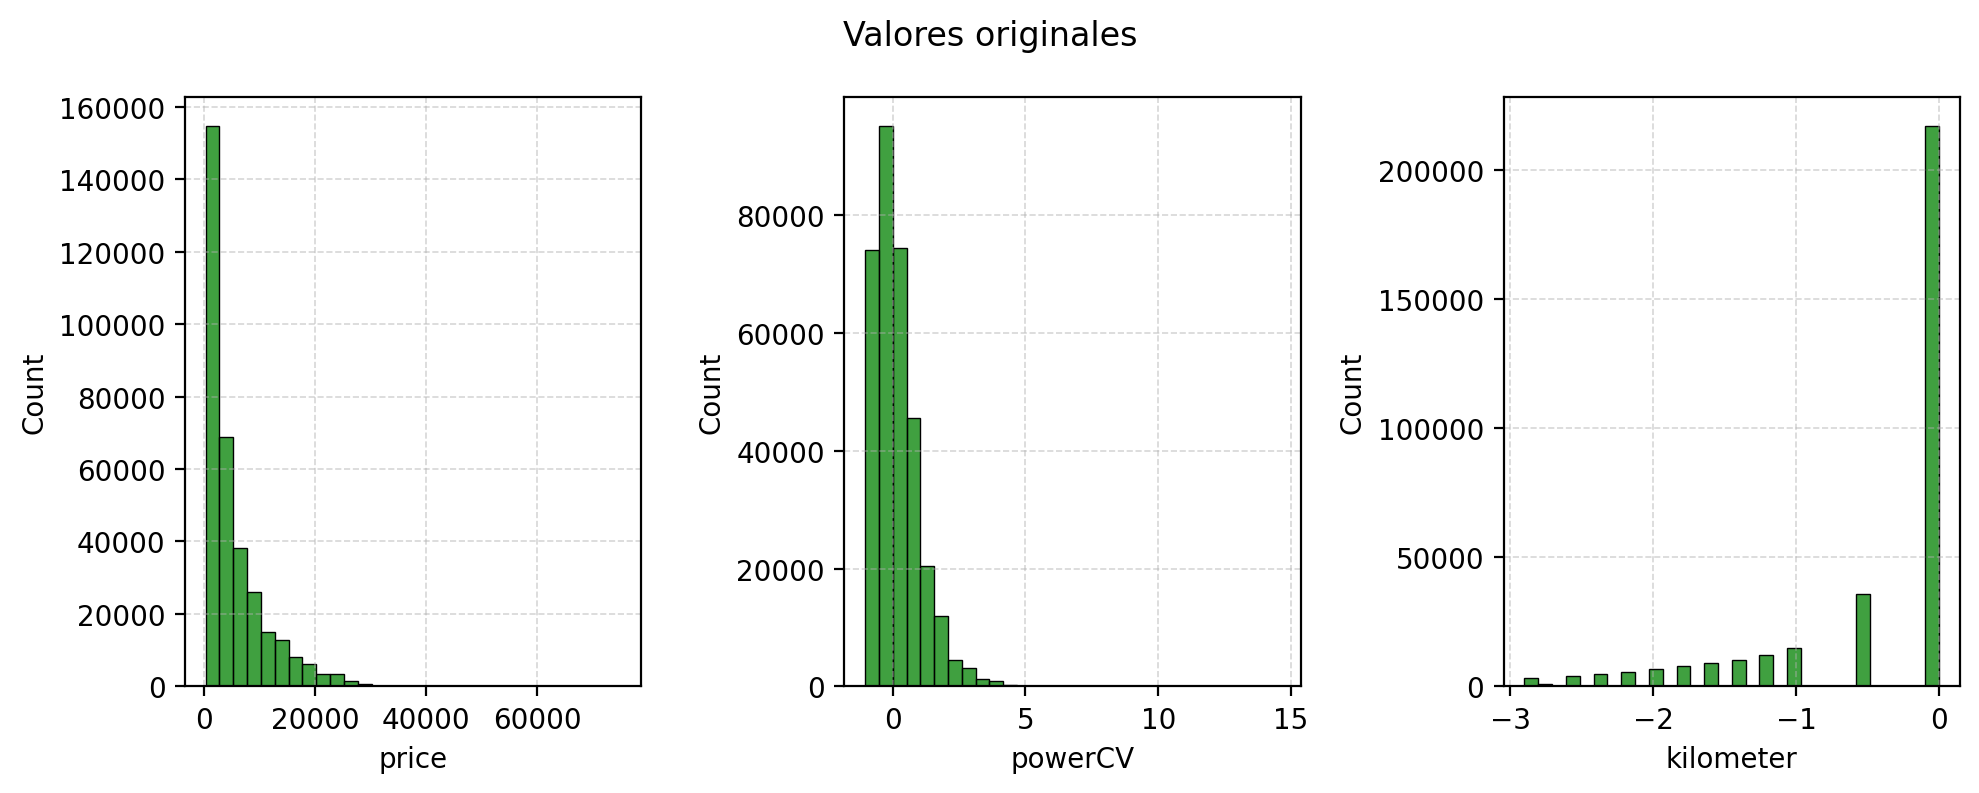

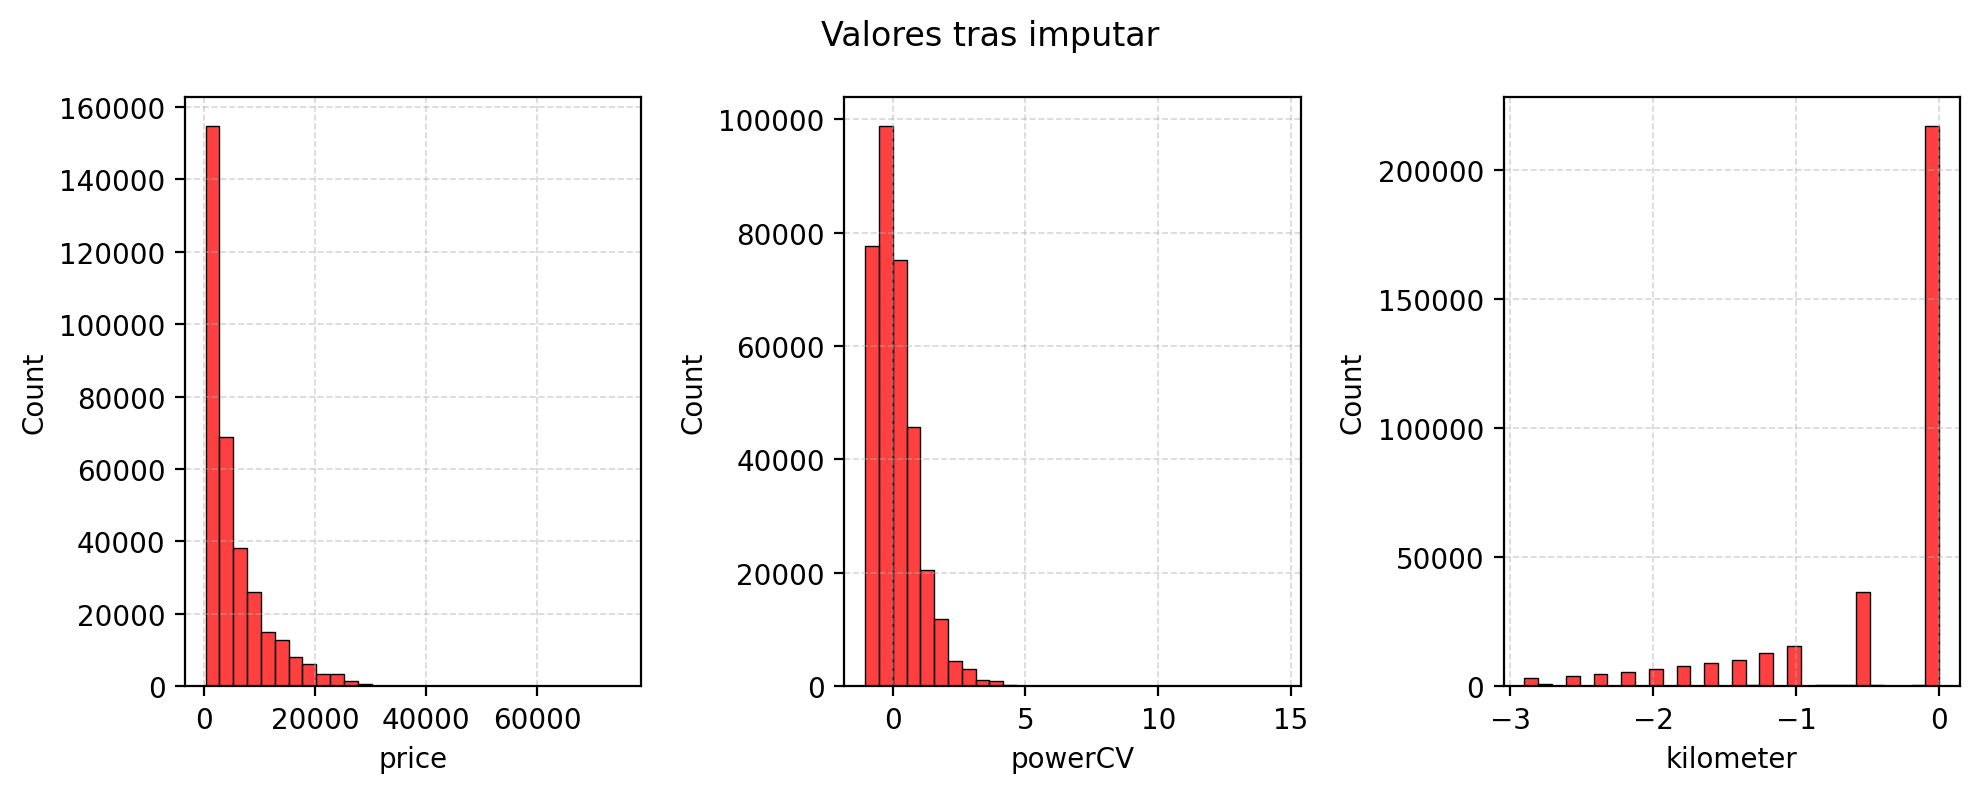

In [35]:
fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(df_filtered_1, x = col, bins = 30,  ax= axes[i], color="green")
plt.suptitle("Valores originales")
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(1,3, figsize = (10,4), dpi = 200)
for i, col in enumerate(df.select_dtypes("number").columns[:3]):
    axes[i].grid(ls = "--", lw = 0.6, alpha = 0.5)
    sns.histplot(df_final, x = col, bins = 30, ax = axes[i], color="red")
plt.suptitle("Valores tras imputar")
plt.tight_layout()

plt.show()


Vemos que, al igual que antes con el LOF, no cambia demasiado después de imputar, también debido a la baja proporción que representan nuestros datos, por lo que la imputación ha sido satisfactoria, no modificando mucho las métricas ni las distribuciones.

In [36]:
df_final.to_csv("datos/df_outlier_cleansed.csv")